In [1]:
import numpy as np
import copy
import scipy
from sklearn.metrics.pairwise import euclidean_distances
from scipy.optimize import minimize
import GPy
import matplotlib.pyplot as plt
from scipy import special
import math
from scipy.stats import norm

In [2]:
def cov_RBF(x1, x2, parameters):  
    
    lengthscale_square =   parameters[:,0]  # lengthscale^2
    variance = parameters[:,1] # sigma^2


    if x1.shape[1]!=x2.shape[1]:
        x1=np.reshape(x1,(-1,x2.shape[1]))

    Euc_dist=euclidean_distances(x1,x2)

    return variance*np.exp(-0.5*np.square(Euc_dist)/lengthscale_square)




def log_llk(X,y,parameters):

    noise_delta = 10**(-6)
    
    parameters = parameters.reshape(-1,2)

    KK_x_x=cov_RBF(X,X,parameters)+np.eye(len(X))*noise_delta     
    if np.isnan(KK_x_x).any(): #NaN
        print("nan in KK_x_x !")   

    try:
        L=scipy.linalg.cholesky(KK_x_x,lower=True)
        alpha=np.linalg.solve(KK_x_x,y)

    except: # singular
        return -np.inf
    
    try:
        first_term = -0.5*np.log(np.linalg.det(KK_x_x))
        
        KK_inv = np.linalg.inv(KK_x_x)
        second_term = -0.5* np.dot(np.dot(y.T,KK_inv),y)
            

    except: # singular
        return -np.inf

    logmarginal = first_term+second_term -0.5*len(y)*np.log(2*3.1415926)
    
    return logmarginal.item()


def optimise(X, y):

    opts ={'maxiter':1000,'maxfun':200,'disp': False}

    bounds = np.array([[0.015**2,0.6**2],[0.01,10]])
    hyper_num = 2
    restart_num = 3**hyper_num
    
    value_holder = []
    candidate_holder = []
    
    for _ in range(restart_num):
      init_hyper = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(50, hyper_num))
      logllk_holder = [0]*init_hyper.shape[0]
      for ii,val in enumerate(init_hyper):           
          logllk_holder[ii] = log_llk(X,y,val) 
          
      x0=init_hyper[np.argmax(logllk_holder)] # we pick one best value from 50 random one as our initial value of the optimization

      # Then we minimze negative likelihood
      res = minimize(lambda x: -log_llk(X,y,parameters=x),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) 

      candidate_holder.append(res.x)
      value_holder.append(log_llk(X,y,res.x))


    best_parameter = candidate_holder[np.argmax(value_holder)]
  
        
    return best_parameter

In [36]:
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock
from botorch.utils.transforms import unnormalize,normalize
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double


from botorch.utils.sampling import draw_sobol_samples

def get_initial_points(bounds,num,device,dtype,seed=0):
    
        train_x = draw_sobol_samples(
        bounds=bounds, n=num, q=1,seed=seed).reshape(num,-1).to(device, dtype=dtype)
        
        return train_x

In [14]:
def MES(X,dim,fstar,model): 
  
  X = X.reshape(-1,dim)
  mean,var = model.predict(X,include_likelihood=False)

  var[var<10**(-12)]=10**(-12)
  gamma = -(fstar-mean)/np.sqrt(var)  

  cdf_part = norm.cdf(gamma)
  out = (gamma*norm.pdf(gamma))/(2*cdf_part)-np.log(cdf_part)

  return out.ravel() 



def MES_acquisition_opt(model,bounds,fstar): #bound should an array of size dim*2

  dim = bounds.shape[0]
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}

  restart_num = 3*dim
  X_candidate = []
  AF_candidate = []

  for i in range(restart_num):
    init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
    value_holder = MES(init_X,dim,fstar,model)
        
    x0=init_X[np.argmax(value_holder)]


    res = minimize(lambda x: -MES(X=x,dim=dim,fstar=fstar,model=model),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) 

    X_temp =  res.x
    AF_temp = MES(X=np.array(X_temp).reshape(-1,1),dim=dim,fstar=fstar,model=model)
    X_candidate.append(X_temp)
    AF_candidate.append(AF_temp)

  X_next = X_candidate[np.argmax(AF_candidate)]


  return X_next

# Experiments

In [43]:
fun = Rosenbrock(dim=2,negate=False)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
 
n_init = 4*dim
iter_num = 12*dim
N=20

fstar = 0.

In [39]:
BO_MES = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    torch.manual_seed(seed)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            fstar_standard = (fstar - Y_BO.mean()) / Y_BO.std()
            fstar_standard = fstar_standard.item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise(train_X,train_Y)
            print('lengthscale is: ',np.sqrt(res[0])) 
            print('variance is: ',res[1])
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = MES_acquisition_opt(m,standard_bounds,fstar_standard)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())

            
    best_record = np.array(best_record)
    BO_MES.append(best_record)

0
lengthscale is:  0.13808353026079379
variance is:  0.875998470969487
lengthscale is:  0.23772069416871913
variance is:  1.1886878499428823
lengthscale is:  0.2301418368340759
variance is:  1.2218757579198218
lengthscale is:  0.2804149516373731
variance is:  1.826697586664574
lengthscale is:  0.3080192814926646
variance is:  2.386824060991544
lengthscale is:  0.30726310782447164
variance is:  2.383211192798494
lengthscale is:  0.3083826785522019
variance is:  2.433521977666239
lengthscale is:  0.33091821467143173
variance is:  3.0862602366927923
lengthscale is:  0.36011853503017605
variance is:  4.226420070604976
lengthscale is:  0.3611489124237321
variance is:  4.497150552545868
lengthscale is:  0.37991064852843043
variance is:  5.468469433388153
lengthscale is:  0.4145884667671756
variance is:  8.078900556788591
lengthscale is:  0.434568902239342
variance is:  9.963135003374102
lengthscale is:  0.43620994859874396
variance is:  9.999999999925508
lengthscale is:  0.43311441680469837


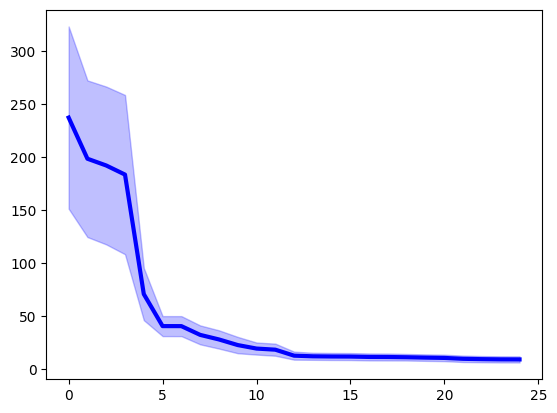

In [40]:
fstar = 0.

N = 20
total_record = np.array(BO_MES)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+MES',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

In [42]:
np.savetxt('Rosenbrock2D_BO_MES', BO_MES, delimiter=',')